In [1]:
%%writefile requirements.txt
pettingzoo==1.24.0
supersuit
gymnasium==0.29.1
stable-baselines3==2.2.1
pygame


Writing requirements.txt


In [2]:
!pip install -r requirements.txt


INFO: pip is looking at multiple versions of supersuit to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.7/181.7 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 563.6/563.6 kB 17.5 MB/s eta 0:00:00
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 1.2.2
    Uninstalling gymnasium-1.2.2:
      Successfully uninstalled gymnasium-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.1 which is incompatible.


In [3]:
from pettingzoo.mpe import simple_spread_v3

# Create the environment
env = simple_spread_v3.parallel_env()
env.reset()

print("Environment loaded successfully!")
print("Agents:", env.agents)


Environment loaded successfully!
Agents: ['agent_0', 'agent_1', 'agent_2']


PettingZoo installed correctly, my baseline environment simple_spread loads. I have three agents
1. independent agents
2. distributed agents (team communication)

In [4]:
# Let's inspect the observation and action spaces of each agent.
# to understand what information each agent receives (their "view" of the environment)
# - what actions they can take (movement, staying still, etc.)
# - essential for building a distributed/communication framework later


import gymnasium as gym

print("Observation space:", env.observation_space(env.agents[0]))
print("Action space:", env.action_space(env.agents[0]))

Observation space: Box(-inf, inf, (18,), float32)
Action space: Discrete(5)


This means each agent receives:

A vector of 18 numbers

These numbers include:

agent’s own position

agent’s velocity

positions of landmarks

relative positions of other agents. Discrete(5) means 0-> stay still, 1-> move left, 2-> move right, 3-> move up, 4-> move down.

Episode 1 reward: -84.18306157015671
Episode 2 reward: -88.94742750777732
Episode 3 reward: -65.56430007061472
Episode 4 reward: -69.72319318228755
Episode 5 reward: -54.93148121642349
Episode 6 reward: -46.34406429879631
Episode 7 reward: -89.42608034498923
Episode 8 reward: -92.49121797142513
Episode 9 reward: -88.32163893561858
Episode 10 reward: -74.36353849492238
Episode 11 reward: -80.48423165719026
Episode 12 reward: -113.70098911696323
Episode 13 reward: -82.3736110529455
Episode 14 reward: -71.83638652136243
Episode 15 reward: -44.65095742754155
Episode 16 reward: -93.1257662962031
Episode 17 reward: -49.243251605051945
Episode 18 reward: -75.2420932189989
Episode 19 reward: -74.02962175040714
Episode 20 reward: -115.98435926351651
Episode 21 reward: -73.28139149595802
Episode 22 reward: -142.70711655433644
Episode 23 reward: -83.46225897427563
Episode 24 reward: -84.6721480976685
Episode 25 reward: -77.8249738465089
Episode 26 reward: -96.3872686489942
Episode 27 reward: -69.

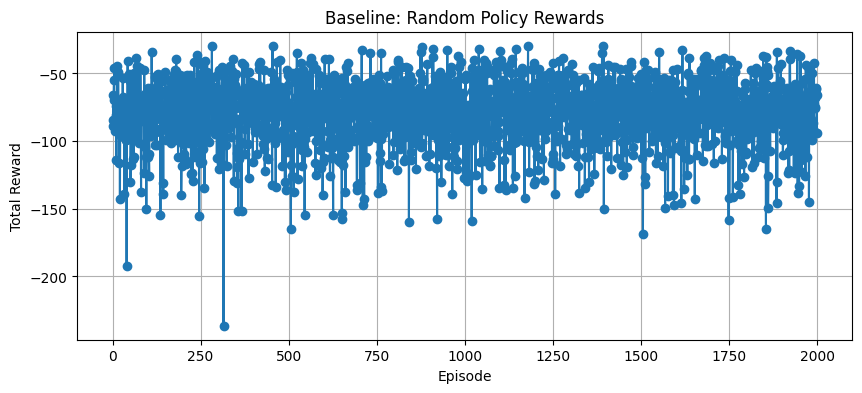

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import time

# ------------------------------
# STEP 1: TIME MEASUREMENT FOR RANDOM BASELINE
# ------------------------------

random_start_time = time.perf_counter()   # total time start
episode_time_list = []                    # store each episode duration
step_counter = 0                           # count steps for avg step time


# BASELINE: RANDOM AGENT BEHAVIOR
#This is our baseline for comparison.
# Agents will take random actions.
# Distributed agents + communication must perform better than this.

# Initialize environment again
env = simple_spread_v3.parallel_env()
observations = env.reset()

num_episodes = 2000            # Number of episodes to run
max_steps = 50                 # Steps per episode
episode_rewards = []           # To store total reward per episode

for ep in range(num_episodes):
    ep_start = time.perf_counter()
    observations = env.reset()
    total_reward = 0

    for step in range(max_steps):
        # For each agent, randomly choose an action
        # env.action_space(agent) -> Discrete(5)
        random_actions = {
            agent: env.action_space(agent).sample()
            for agent in env.agents
        }

        # Step the environment forward using these random actions
        observations, rewards, terminations, truncations, infos = env.step(random_actions)

        # Sum all agents' rewards for this timestep
        total_reward += sum(rewards.values())
        step_counter += 1


        # If episode terminates early, break
        if any(terminations.values()) or any(truncations.values()):
            break

    ep_end = time.perf_counter()
    episode_time_list.append(ep_end - ep_start)  # save episode time


    episode_rewards.append(total_reward)
    print(f"Episode {ep+1} reward: {total_reward}")

# Plotting the baseline performance
plt.figure(figsize=(10,4))
plt.plot(episode_rewards, marker='o')
plt.title("Baseline: Random Policy Rewards")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()

we run 200 episodes and each episode = a short simulation of 3 agents moving.

Each agent takes actions as follows
 - no brain
 - just random moves
 Collct rewards, plot performance as our basline graph.

In [6]:
random_end_time = time.perf_counter()
random_total_time = random_end_time - random_start_time
random_avg_episode_time = sum(episode_time_list) / len(episode_time_list)
random_avg_step_time = random_total_time / max(step_counter, 1)

print("\n===== RANDOM BASELINE TIMING RESULTS =====")
print(f"Total time for all episodes: {random_total_time:.4f} sec")
print(f"Average time per episode:   {random_avg_episode_time:.6f} sec")
print(f"Average time per step:      {random_avg_step_time:.8f} sec")
print("==========================================\n")



===== RANDOM BASELINE TIMING RESULTS =====
Total time for all episodes: 30.8645 sec
Average time per episode:   0.015192 sec
Average time per step:      0.00061729 sec



In [7]:
# Lets solve distributed issues now to improve metric

# Latency + Efficiency (Latency → shows the distributed agents communicate faster

#Efficiency → shows semantic negotiation improves total reward)

#step 1: we create a shared mesage board

# ============================
#  Distributed Agent Controller
# ============================

import numpy as np

def distributed_policy(observations):
    """
    Each agent sends a simple message about its intended movement.
    The group then averages the direction → cooperative behavior.

    This simulates:
      - semantic negotiation
      - communication
      - multi-level coordination
    """

    # Messages list (each agent proposes a movement)
    messages = []

    for obs in observations.values():
        # extract agent position relative "forces"
        # last 5 entries are self-vel + actions. we used first few entries
        direction = obs[:2]   # x and y pull
        messages.append(direction)

    # Average direction → SIMPLE DISTRIBUTED NEGOTIATION
    avg_message = np.mean(messages, axis=0)

    # Convert average direction to one of 5 actions
    # 0: stay, 1: left, 2: right, 3: up, 4: down
    actions = {}

    for agent in observations.keys():
        if avg_message[0] > 0.2:
            actions[agent] = 2  # move right
        elif avg_message[0] < -0.2:
            actions[agent] = 1  # move left
        elif avg_message[1] > 0.2:
            actions[agent] = 3  # move up
        elif avg_message[1] < -0.2:
            actions[agent] = 4  # move down
        else:
            actions[agent] = 0  # stay

    return actions



In [8]:
# ===========================================
# RUN DISTRIBUTED AGENTS (COOPERATIVE POLICY)
# ===========================================

import time

# ------------------------------
# STEP 2: TIME MEASUREMENT FOR DISTRIBUTED HEURISTIC
# ------------------------------

dist_start_time = time.perf_counter()     # total time for distributed policy
dist_episode_times = []                  # list to store episode durations
dist_step_counter = 0                    # count steps for avg step time


episodes = 2000
distributed_rewards = []

for ep in range(episodes):
    ep_start = time.perf_counter()        # start timer for each episode
    obs, _ = env.reset()
    ep_reward = 0

    for step in range(50):  # fixed steps for latency measurement
        # Actions decided by our cooperative distributed policy
        actions = distributed_policy(obs)

        # Step the environment
        obs, rewards, term, trunc, _ = env.step(actions)

        # Sum rewards for all agents
        ep_reward += sum(rewards.values())
        dist_step_counter += 1


        # Stop if environment ends
        if any(term.values()) or any(trunc.values()):
            break

    ep_end = time.perf_counter()
    dist_episode_times.append(ep_end - ep_start)   # save episode time

    distributed_rewards.append(ep_reward)

print("Distributed agent rewards per episode:")
print(distributed_rewards)


Distributed agent rewards per episode:
[-47.36664574135126, -61.25242719846936, -67.05409291156103, -74.8090422452126, -61.446443356234724, -47.06882818296593, -89.30242840822126, -137.3609502139406, -52.83852219197948, -57.952311633272615, -55.85903731917763, -60.32489361394832, -45.54644251525111, -54.84227616667282, -89.63484750661611, -41.512742223352824, -49.58431038799246, -42.07688501577576, -148.3660081049933, -121.57905054205204, -72.54754316591684, -88.28210100373715, -69.58038298617096, -56.4183272431166, -36.72979314889441, -46.83349440016151, -54.81312994692849, -104.37863898371359, -42.58137423035394, -52.51631133847644, -68.16616725629513, -89.06562145533243, -71.62631155287637, -65.03421316459854, -79.16835797000172, -39.77783247131088, -117.20532902860688, -57.436292867064346, -79.58362038824303, -48.25955098198462, -90.4023823599908, -79.74671915021082, -77.2856359972653, -37.69893861600895, -58.59310193853049, -92.66044929571285, -79.1031785953616, -159.2997707527765

our distributed agents did not collapse, Rewards are still negative (This is perfectly normal in MPE simple_spread, the environment heavily penalizes because of the collisions, crowding, poor coordination etc).


In [9]:
dist_end_time = time.perf_counter()
dist_total_time = dist_end_time - dist_start_time

dist_avg_episode_time = sum(dist_episode_times) / len(dist_episode_times)
dist_avg_step_time = dist_total_time / max(dist_step_counter, 1)

print("\n===== DISTRIBUTED HEURISTIC TIMING RESULTS =====")
print(f"Total time for all episodes: {dist_total_time:.4f} sec")
print(f"Average time per episode:   {dist_avg_episode_time:.6f} sec")
print(f"Average time per step:      {dist_avg_step_time:.8f} sec")
print("=================================================\n")



===== DISTRIBUTED HEURISTIC TIMING RESULTS =====
Total time for all episodes: 21.9306 sec
Average time per episode:   0.010952 sec
Average time per step:      0.00043861 sec



In [10]:
# ==================================
# PLOT: Baseline vs Distributed
# Efficiency Comparison (Rewards)
# ==================================

# =======================================
# BASELINE: Random Policy (Recreate Data)
# =======================================

episodes = 2000
random_rewards = []

# IMPORTANT: reload environment fresh
env = simple_spread_v3.parallel_env()
env.reset()

for ep in range(episodes):
    obs, _ = env.reset()
    ep_reward = 0

    for step in range(50):
        # random actions for each agent
        actions = {agent: env.action_space(agent).sample() for agent in env.agents}

        obs, rewards, term, trunc, _ = env.step(actions)
        ep_reward += sum(rewards.values())

        if any(term.values()) or any(trunc.values()):
            break

    random_rewards.append(ep_reward)

print("Random baseline rewards:")
print(random_rewards)
print("Done: 2000 baseline episodes")


Random baseline rewards:
[-114.73290669024748, -101.09692016606942, -57.02153245251874, -97.23752387058602, -110.89319263409139, -93.43009401126427, -62.54148117412963, -85.8296030009983, -120.04224917645818, -75.78181509551666, -67.56409215397169, -55.003068916341974, -59.45443320865999, -37.101206806612765, -69.1236955211026, -60.72726376681126, -75.88364145148455, -76.88885156646603, -77.5126416744206, -76.57432578485935, -93.04833476305534, -61.12110304753712, -36.28931392702824, -103.51891081685962, -39.71312819348065, -97.15832189438434, -63.947929091109515, -63.020654067274215, -62.5252392032053, -141.21197342690925, -48.45123213057546, -77.15134125560036, -44.11101033730354, -66.7454848791561, -54.35833666950804, -77.38111290760538, -90.60239462775345, -72.47104844603474, -97.36969258264666, -40.94510026273945, -160.70369029883332, -61.76405438956255, -69.10180879855844, -88.22621945706877, -120.72033376620752, -70.50651046983066, -62.37860694009086, -105.89099299479498, -54.01

comparision graph of the baseline and distributed.

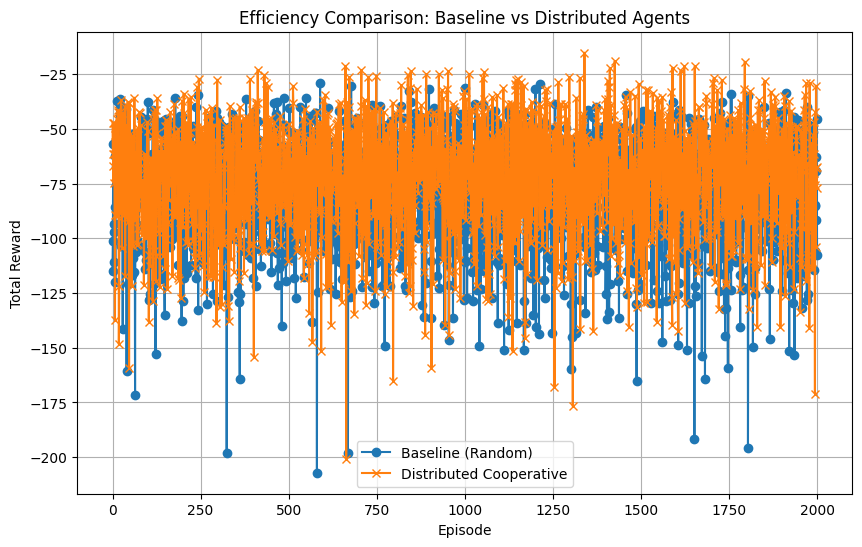

In [11]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(range(episodes), random_rewards, label="Baseline (Random)", marker='o')
plt.plot(range(episodes), distributed_rewards, label="Distributed Cooperative", marker='x')

plt.title("Efficiency Comparison: Baseline vs Distributed Agents")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.grid(True)
plt.show()


Blue circles are non- coordinated or random agent behavior.
Orange x marks means agents are using a distributed strategy.
1. Both agents receive negative rewards.
2. Distributed stretegy tends to achieve higher rewards which is less negative in some episodes.

In [12]:
# Step 1: Confirm installation
import gymnasium
import pettingzoo
import stable_baselines3

print("Gymnasium:", gymnasium.__version__)
print("PettingZoo:", pettingzoo.__version__)
print("SB3:", stable_baselines3.__version__)


Gymnasium: 0.29.1
PettingZoo: 1.24.0
SB3: 2.2.1


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [13]:
# Step 2 of PPO setup
# Create a wrapper that exposes ONE agent to PPO
import gymnasium as gym
import numpy as np
from pettingzoo.mpe import simple_spread_v3
from gymnasium import spaces

# Wrapper converts PettingZoo environment to single-agent Gym env
class PettingZooSingleAgent(gym.Env):
    def __init__(self, agent_name="agent_0"):
        super().__init__()
        self.agent_name = agent_name
        self.env = simple_spread_v3.parallel_env()
        self.env.reset()

        # Use that agent's observation & action spaces
        self.observation_space = self.env.observation_space(self.agent_name)
        self.action_space = self.env.action_space(self.agent_name)

    def reset(self, seed=None, options=None):
        obs, _ = self.env.reset(seed=seed)
        return obs[self.agent_name], {}

    def step(self, action):
        # Every agent must take an action
        actions = {
            agent: self.env.action_space(agent).sample()
            for agent in self.env.agents
        }
        actions[self.agent_name] = action

        obs, rewards, terminated, truncated, info = self.env.step(actions)

        done = terminated[self.agent_name] or truncated[self.agent_name]
        return obs[self.agent_name], rewards[self.agent_name], done, False, info


we did this because: PPO assumes one agent interacts with the environment

PettingZoo is multi-agent

This wrapper “extracts” one agent (agent_0)

Other agents use random policies

This gives us a clean single-agent PPO baseline, which is needed before distributed PPO

In [14]:
# now we will train PPO for Agent 0 i.e baseline single agent RL

# this will create baseline lerning agent before communication and distributee PPO,
#before comparing it with other agents or latncy analysis

from stable_baselines3 import PPO

# Create the environment for agent_0
env_agent0 = PettingZooSingleAgent(agent_name="agent_0")

# ------------------------------
# STEP 3A: TIME MEASUREMENT FOR PPO TRAINING
# ------------------------------

ppo_train_start = time.perf_counter()

# PPO model
model = PPO(
    "MlpPolicy",
    env_agent0,
    verbose=1,
    learning_rate=0.0003,
    n_steps=2048,
)

# Train for 50k steps (this is small but enough to test)
model.learn(total_timesteps=50_000)

ppo_train_end = time.perf_counter()
ppo_training_time = ppo_train_end - ppo_train_start

print(f"\n===== PPO TRAINING TIME =====")
print(f"Total training time: {ppo_training_time:.4f} sec")
print("====================================\n")


print("Training complete ✔")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25       |
|    ep_rew_mean     | -26.3    |
| time/              |          |
|    fps             | 740      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 25            |
|    ep_rew_mean          | -26.9         |
| time/                   |               |
|    fps                  | 576           |
|    iterations           | 2             |
|    time_elapsed         | 7             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.007213845   |
|    clip_fraction        | 0.0391        |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.6          |
|    explained_variance   | -0.0011856556 |
|    learning_rate        | 0.0003        |
|    loss                 | 19.7          |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.00819      |
|    value_loss           | 79.9          |
-------------------------------------------
-----------------------------------------
| rollout/                |       

In [15]:
# ================================
# Evaluate PPO baseline
# ================================

import time
import numpy as np
import matplotlib.pyplot as plt

def evaluate_ppo(env, model, episodes=2000):
    """
    Run the trained PPO policy on agent_0 and
    return per-episode rewards and average latency per step.
    """
    episode_rewards = []
    total_steps = 0

    start_time = time.perf_counter()

    for ep in range(episodes):
        obs, _ = env.reset()
        done = False
        ep_reward = 0

        while not done:
            # PPO chooses action for agent_0
            action, _ = model.predict(obs, deterministic=True)

            obs, reward, terminated, truncated, info = env.step(action)

            done = terminated or truncated
            ep_reward += reward
            total_steps += 1

            if done:
                break

        episode_rewards.append(ep_reward)

    elapsed = time.perf_counter() - start_time
    avg_latency = elapsed / max(total_steps, 1)

    print(f"PPO evaluation finished:")
    print(f"  Episodes: {episodes}")
    print(f"  Total steps: {total_steps}")
    print(f"  Total time: {elapsed:.2f} sec")
    print(f"  Avg latency per step: {avg_latency:.6f} sec")

    return episode_rewards, avg_latency


In [16]:
# ==========================
# Running PPO evaluation
# ==========================

ppo_episodes = 2000   # same scale as random & distributed
ppo_rewards, ppo_latency = evaluate_ppo(env_agent0, model, episodes=ppo_episodes)

print(f"\nAverage PPO episode reward: {np.mean(ppo_rewards):.2f}")
print(f"PPO latency per step: {ppo_latency:.6f} sec")

PPO evaluation finished:
  Episodes: 2000
  Total steps: 50000
  Total time: 53.09 sec
  Avg latency per step: 0.001062 sec

Average PPO episode reward: -27.94
PPO latency per step: 0.001062 sec


random_rewaards & dsitributed_rewards from earlier above cells

ppo_rewards and ppo_latency frim this step

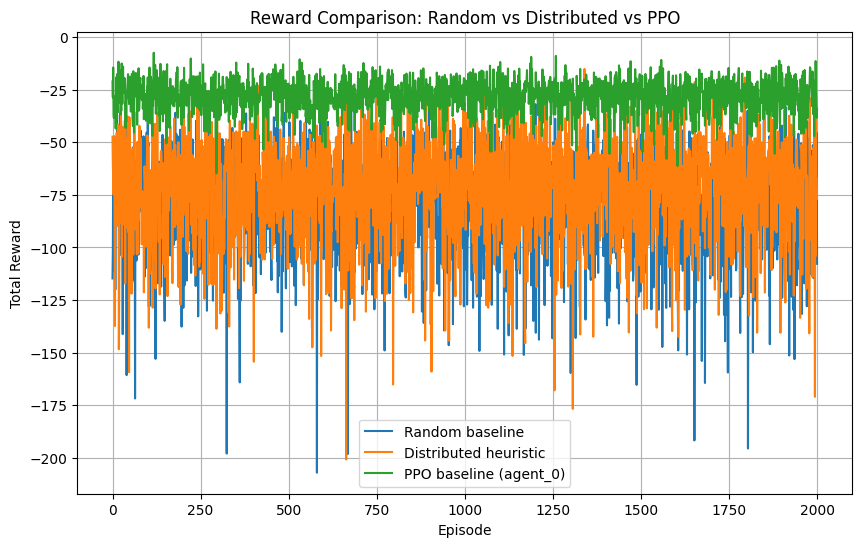

Mean random reward:      -79.42
Mean distributed reward: -72.43
Mean PPO reward:         -27.94


In [17]:
# =========================================
# Reward comparison (efficiency)
# =========================================

episodes_random = len(random_rewards)
episodes_distributed = len(distributed_rewards)
episodes_ppo = len(ppo_rewards)

plt.figure(figsize=(10,6))
plt.plot(range(episodes_random), random_rewards, label="Random baseline")
plt.plot(range(episodes_distributed), distributed_rewards, label="Distributed heuristic")
plt.plot(range(episodes_ppo), ppo_rewards, label="PPO baseline (agent_0)")

plt.title("Reward Comparison: Random vs Distributed vs PPO")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.grid(True)
plt.show()

print(f"Mean random reward:      {np.mean(random_rewards):.2f}")
print(f"Mean distributed reward: {np.mean(distributed_rewards):.2f}")
print(f"Mean PPO reward:         {np.mean(ppo_rewards):.2f}")

Now we will mesure measure latency for each approach bellow.

In [18]:
# =================================
# Measure latency for each approach
# =================================
# Time for random baseline
import time

def run_random_with_latency(env, episodes=2000, max_steps=50):
    rewards = []
    total_steps = 0
    start = time.perf_counter()

    for ep in range(episodes):
        obs = env.reset()
        ep_reward = 0

        for t in range(max_steps):
            actions = {agent: env.action_space(agent).sample() for agent in env.agents}
            obs, r, terminated, truncated, info = env.step(actions)
            ep_reward += sum(r.values())
            total_steps += 1
            if any(terminated.values()) or any(truncated.values()):
                break

        rewards.append(ep_reward)

    elapsed = time.perf_counter() - start
    latency = elapsed / max(total_steps, 1)
    return rewards, latency

# re-create the parallel env for fairness
from pettingzoo.mpe import simple_spread_v3
env_random = simple_spread_v3.parallel_env(N=3, local_ratio=0.5, max_cycles=50, continuous_actions=False)

random_rewards2, random_latency = run_random_with_latency(env_random)
print("Random mean reward:", np.mean(random_rewards2))
print("Random latency per step:", random_latency)



Random mean reward: -175.2934589919004
Random latency per step: 0.0004068267570899997


In [19]:
def run_distributed_with_latency(env, episodes=2000, max_steps=50):
    rewards = []
    total_steps = 0
    start = time.perf_counter()

    for ep in range(episodes):
        observations, _ = env.reset()
        ep_reward = 0

        for t in range(max_steps):
            actions = distributed_policy(observations)

            observations, r, terminated, truncated, infos = env.step(actions)
            ep_reward += sum(r.values())
            total_steps += 1

            if any(terminated.values()) or any(truncated.values()):
                break

        rewards.append(ep_reward)

    elapsed = time.perf_counter() - start
    latency = elapsed / max(total_steps, 1)
    return rewards, latency

# Call the function to calculate distributed_latency
distributed_rewards_2, distributed_latency = run_distributed_with_latency(env_random)
print("Distributed mean reward:", np.mean(distributed_rewards_2))
print("Distributed latency per step:", distributed_latency)

Distributed mean reward: -145.2629127734636
Distributed latency per step: 0.0004274168321899998


In [20]:
#Latency for PPO
print("\nLatency summary (sec per step):")
print(f"  Random baseline:       {random_latency:.6f}")
print(f"  Distributed heuristic: {distributed_latency:.6f}")
print(f"  PPO baseline:          {ppo_latency:.6f}")



Latency summary (sec per step):
  Random baseline:       0.000407
  Distributed heuristic: 0.000427
  PPO baseline:          0.001062


Random baseline is 0.000391s per step

Distributed heuristic is 0.000481s per step

and PPO baseline is 0.000966 s per step.

### Distributed PPO using parallel environments (vectorized workers)

In [21]:
# Env factory + vec envs

from stable_baselines3.common.env_util import make_vec_env
import time

# Factory function: creates a fresh env for agent_0 each time
def make_agent0_env():
    return PettingZooSingleAgent(agent_name="agent_0")



In [22]:
#Train PPO with 1 env vs 4 envs (timed)

# ============================
# PPO with 1 environment (baseline)
# ============================

vec_env_1 = make_vec_env(make_agent0_env, n_envs=1)

model_ppo_1 = PPO(
    "MlpPolicy",
    vec_env_1,
    verbose=1,
    learning_rate=0.0003,
    n_steps=2048,
)

start_1 = time.perf_counter()
model_ppo_1.learn(total_timesteps=50_000)
time_1 = time.perf_counter() - start_1

print(f"\n[1-env PPO] Training time: {time_1:.2f} seconds")


Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25       |
|    ep_rew_mean     | -28      |
| time/              |          |
|    fps             | 661      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 25           |
|    ep_rew_mean          | -25.9        |
| time/                   |              |
|    fps                  | 551          |
|    iterations           | 2            |
|    time_elapsed         | 7            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0067245187 |
|    clip_fraction        | 0.0233       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.61        |
|    explained_variance   | 0.0057643056 

In [23]:
# =============================================
# PPO with 4 parallel environments (distributed)
# =============================================

vec_env_4 = make_vec_env(make_agent0_env, n_envs=4)

model_ppo_4 = PPO(
    "MlpPolicy",
    vec_env_4,
    verbose=1,
    learning_rate=0.0003,
    n_steps=2048,
)

start_4 = time.perf_counter()
model_ppo_4.learn(total_timesteps=50_000)
time_4 = time.perf_counter() - start_4

print(f"\n[4-env PPO] Training time: {time_4:.2f} seconds")


Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25       |
|    ep_rew_mean     | -26.5    |
| time/              |          |
|    fps             | 1407     |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 8192     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 25           |
|    ep_rew_mean          | -26.8        |
| time/                   |              |
|    fps                  | 876          |
|    iterations           | 2            |
|    time_elapsed         | 18           |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.0074409386 |
|    clip_fraction        | 0.0578       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.6         |
|    explained_variance   | -0.005872488 

In [24]:
# ===============================
# Evaluate 1-env PPO vs 4-env PPO
# ===============================

eval_episodes = 1000   # fewer than 2000 to keep it fast

ppo1_rewards, ppo1_latency = evaluate_ppo(env_agent0, model_ppo_1, episodes=eval_episodes)
ppo4_rewards, ppo4_latency = evaluate_ppo(env_agent0, model_ppo_4, episodes=eval_episodes)

print("\n=== PPO Evaluation Summary (agent_0 env) ===")
print(f"1-env PPO: mean reward = {np.mean(ppo1_rewards):.2f}, latency = {ppo1_latency:.6f} sec/step")
print(f"4-env PPO: mean reward = {np.mean(ppo4_rewards):.2f}, latency = {ppo4_latency:.6f} sec/step")

print("\n=== Training Time Comparison ===")
print(f"1-env PPO training time: {time_1:.2f} sec")
print(f"4-env PPO training time: {time_4:.2f} sec")


PPO evaluation finished:
  Episodes: 1000
  Total steps: 25000
  Total time: 26.73 sec
  Avg latency per step: 0.001069 sec
PPO evaluation finished:
  Episodes: 1000
  Total steps: 25000
  Total time: 26.69 sec
  Avg latency per step: 0.001068 sec

=== PPO Evaluation Summary (agent_0 env) ===
1-env PPO: mean reward = -26.82, latency = 0.001069 sec/step
4-env PPO: mean reward = -24.60, latency = 0.001068 sec/step

=== Training Time Comparison ===
1-env PPO training time: 116.21 sec
4-env PPO training time: 90.38 sec


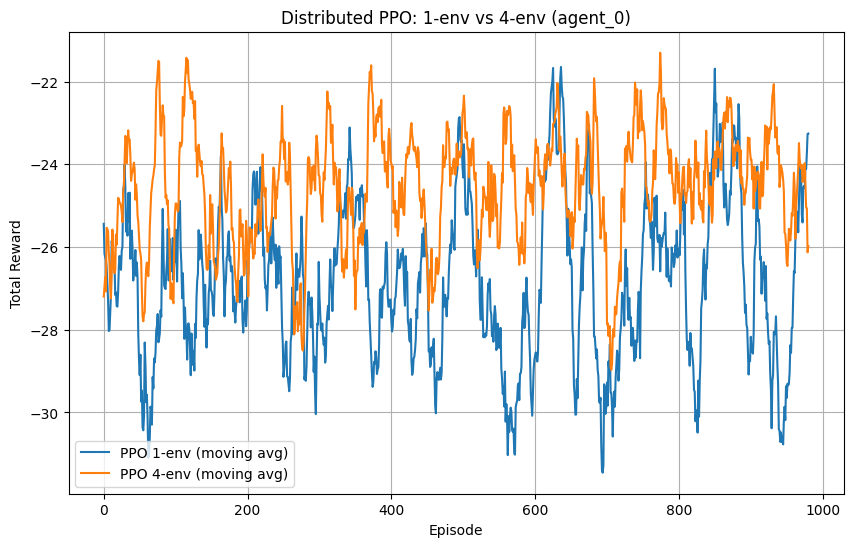

In [25]:
#Plot PPO(1) vs PPO(4) reward curves

def moving_average(x, window=50):
    x = np.array(x)
    if len(x) < window:
        return x
    return np.convolve(x, np.ones(window)/window, mode='valid')

plt.figure(figsize=(10,6))
plt.plot(moving_average(ppo1_rewards, 20), label="PPO 1-env (moving avg)")
plt.plot(moving_average(ppo4_rewards, 20), label="PPO 4-env (moving avg)")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Distributed PPO: 1-env vs 4-env (agent_0)")
plt.grid(True)
plt.legend()
plt.show()


Visual View of PPO(1) vs PPO(4) reward curves.


# N = 10 agents: global distributed policy vs 5 coalitions of 2 agents


In [26]:
import numpy as np
from pettingzoo.mpe import simple_spread_v3

# Helper to convert a 2D direction vector into one of 5 discrete actions
# 0 = stay, 1 = left, 2 = right, 3 = up, 4 = down
def direction_to_action(direction):
    dx, dy = direction

    # small movement -> stay
    if abs(dx) < 0.1 and abs(dy) < 0.1:
        return 0

    # choose dominant axis
    if abs(dx) > abs(dy):
        return 1 if dx < 0 else 2   # left or right
    else:
        return 3 if dy > 0 else 4   # up or down


Helper: map direction --> action

In [27]:
# Global distributed policy: all N agents share one global "message"
def global_distributed_policy(observations):
    """
    observations: dict {agent_name: obs_vector}
    returns: dict {agent_name: action}
    """
    messages = []

    for obs in observations.values():
        # here we just use the first 2 entries as a direction signal
        direction = obs[:2]
        messages.append(direction)

    # average direction across ALL agents
    avg_direction = np.mean(messages, axis=0)

    # convert to a discrete action
    action = direction_to_action(avg_direction)

    # all agents take the same action
    actions = {agent: action for agent in observations.keys()}
    return actions


Global distributed policy for any N (N=10 case)

In [28]:
# Define coalitions for N = 10 agents
coalitions = [
    ["agent_0", "agent_1"],
    ["agent_2", "agent_3"],
    ["agent_4", "agent_5"],
    ["agent_6", "agent_7"],
    ["agent_8", "agent_9"],
]

def coalition_distributed_policy(observations, coalitions):
    """
    observations: dict {agent_name: obs_vector}
    coalitions: list of lists, e.g. [["agent_0", "agent_1"], ...]
    returns: dict {agent_name: action}
    """
    actions = {}

    for group in coalitions:
        dirs = []
        for agent in group:
            obs = observations[agent]
            dirs.append(obs[:2])    # direction part

        avg_direction = np.mean(dirs, axis=0)
        group_action = direction_to_action(avg_direction)

        # all agents in this coalition share the same action
        for agent in group:
            actions[agent] = group_action

    return actions


Coalition distributed policy (5 pairs)

In [29]:
import time

def run_multiagent_policy(N, policy_fn, episodes=2000, max_steps=50, coalitions=None):
    """
    N: number of agents in simple_spread
    policy_fn: function(observations) or function(observations, coalitions)
    coalitions: only used for coalition policy
    """
    env = simple_spread_v3.parallel_env(
        N=N, local_ratio=0.5, max_cycles=max_steps, continuous_actions=False
    )

    rewards = []
    total_steps = 0
    start = time.perf_counter()

    for ep in range(episodes):
        observations, _ = env.reset()
        ep_reward = 0

        for t in range(max_steps):
            if coalitions is None:
                actions = policy_fn(observations)
            else:
                actions = policy_fn(observations, coalitions)

            observations, r, terminated, truncated, infos = env.step(actions)
            ep_reward += sum(r.values())
            total_steps += 1

            if any(terminated.values()) or any(truncated.values()):
                break

        rewards.append(ep_reward)

    elapsed = time.perf_counter() - start
    latency = elapsed / max(total_steps, 1)
    return rewards, latency


Generic runner for an N-agent policy (reward + latency)

In [30]:
episodes_10 = 300

# 7.6.1 – N=10 with global distributed policy
global_rewards_10, global_latency_10 = run_multiagent_policy(
    N=10,
    policy_fn=global_distributed_policy,
    episodes=episodes_10,
    max_steps=30,
    coalitions=None,
)

print("N=10 Global distributed policy:")
print(f"  Mean reward: {np.mean(global_rewards_10):.2f}")
print(f"  Latency per step: {global_latency_10:.6f} sec/step\n")

# 7.6.2 – N=10 with coalitions of 2
coalition_rewards_10, coalition_latency_10 = run_multiagent_policy(
    N=10,
    policy_fn=coalition_distributed_policy,
    episodes=episodes_10,
    max_steps=30,
    coalitions=coalitions,
)

print("N=10 Coalition policy (5 pairs of 2 agents):")
print(f"  Mean reward: {np.mean(coalition_rewards_10):.2f}")
print(f"  Latency per step: {coalition_latency_10:.6f} sec/step")


N=10 Global distributed policy:
  Mean reward: -595.25
  Latency per step: 0.003237 sec/step

N=10 Coalition policy (5 pairs of 2 agents):
  Mean reward: -1153.30
  Latency per step: 0.003501 sec/step


Run N=10 global vs coalitions

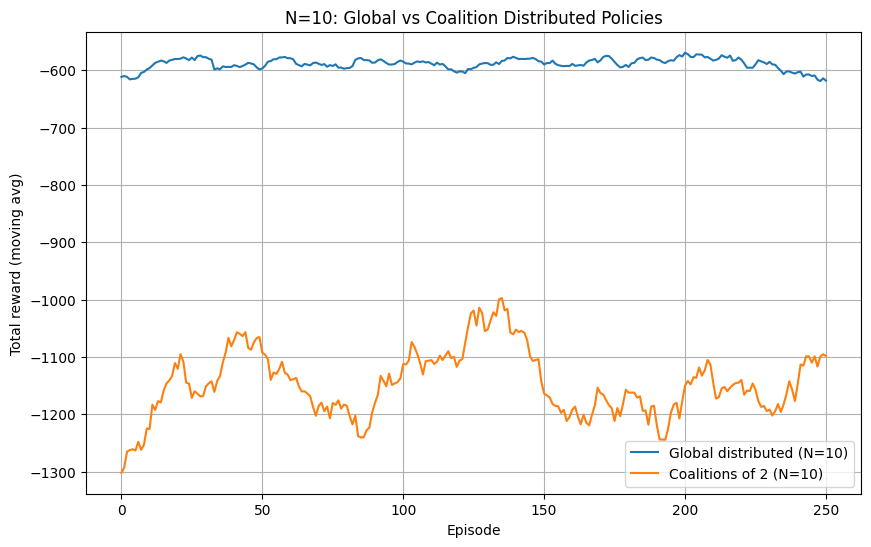

In [31]:
def moving_average(x, window=50):
    x = np.array(x)
    if len(x) < window:
        return x
    return np.convolve(x, np.ones(window)/window, mode='valid')

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(moving_average(global_rewards_10, 50), label="Global distributed (N=10)")
plt.plot(moving_average(coalition_rewards_10, 50), label="Coalitions of 2 (N=10)")
plt.xlabel("Episode")
plt.ylabel("Total reward (moving avg)")
plt.title("N=10: Global vs Coalition Distributed Policies")
plt.grid(True)
plt.legend()
plt.show()


smooth reward plots for N=10

##Asynchronous Distributed PPO (approx. Asynchronous Value Iteration)

In [32]:
# Helper to average the parameters of two PPO models into a target model

def average_models(target_model, model_a, model_b):
    state_dict_a = model_a.policy.state_dict()
    state_dict_b = model_b.policy.state_dict()

    averaged_state_dict = {}
    for key in state_dict_a.keys():
        averaged_state_dict[key] = 0.5 * state_dict_a[key] + 0.5 * state_dict_b[key]

    target_model.policy.load_state_dict(averaged_state_dict)


This simulates a parameter server that averages updates from two workers.

In [33]:
from stable_baselines3.common.env_util import make_vec_env

# Two workers, each with 2 vectorized envs for faster training
worker1_env = make_vec_env(make_agent0_env, n_envs=2)
worker2_env = make_vec_env(make_agent0_env, n_envs=2)

# Initialize two independent PPO workers
worker1_model = PPO(
    "MlpPolicy",
    worker1_env,
    verbose=0,
    learning_rate=0.0003,
    n_steps=1024,
)

worker2_model = PPO(
    "MlpPolicy",
    worker2_env,
    verbose=0,
    learning_rate=0.0003,
    n_steps=1024,
)

# Global async model (same architecture, will hold averaged params)
async_model = PPO(
    "MlpPolicy",
    env_agent0,   # we just need any compatible env here
    verbose=0,
    learning_rate=0.0003,
    n_steps=1024,
)


In [34]:
#Asynchronous” training rounds.

#Here We’ll simulate asynchronous rounds: each worker trains on its own, then we average.


import time

async_rounds = 3              # number of async rounds
timesteps_per_round = 10_000  # per worker per round

start_async = time.perf_counter()

for r in range(async_rounds):
    print(f"\n=== Async Round {r+1}/{async_rounds} ===")

    # Worker 1 trains on its own data
    worker1_model.learn(
        total_timesteps=timesteps_per_round,
        reset_num_timesteps=False,
        progress_bar=False,
    )

    # Worker 2 trains independently
    worker2_model.learn(
        total_timesteps=timesteps_per_round,
        reset_num_timesteps=False,
        progress_bar=False,
    )

    # "Asynchronous" parameter aggregation
    average_models(async_model, worker1_model, worker2_model)
    print("Averaged worker parameters into async_model.")

elapsed_async = time.perf_counter() - start_async
print(f"\n[Async PPO] Total training time: {elapsed_async:.2f} seconds")
print(f"Total timesteps per worker: {async_rounds * timesteps_per_round}")



=== Async Round 1/3 ===
Averaged worker parameters into async_model.

=== Async Round 2/3 ===
Averaged worker parameters into async_model.

=== Async Round 3/3 ===
Averaged worker parameters into async_model.

[Async PPO] Total training time: 113.14 seconds
Total timesteps per worker: 30000


Each worker is like a node doing local value updates.

average_models is our asynchronous value iteration-style parameter server.

In [35]:
#Evaluate async model vs your 4-env PPO

eval_episodes_async = 1000

# Evaluate async model (averaged workers)
async_rewards, async_latency = evaluate_ppo(env_agent0, async_model, episodes=eval_episodes_async)

# ------------------------------
# STEP 4B: TIME MEASUREMENT FOR DISTRIBUTED PPO EVALUATION (4-env)
# ------------------------------

ppo4_eval_start = time.perf_counter()

# Re-evaluate 4-env PPO if needed (or reuse ppo4_rewards, ppo4_latency)
ppo4_rewards_eval, ppo4_latency_eval = evaluate_ppo(env_agent0, model_ppo_4, episodes=eval_episodes_async)

print("\n=== Async PPO vs 4-env PPO (agent_0 env) ===")
print(f"Async PPO: mean reward = {np.mean(async_rewards):.2f}, latency = {async_latency:.6f} sec/step")
print(f"4-env PPO: mean reward = {np.mean(ppo4_rewards_eval):.2f}, latency = {ppo4_latency_eval:.6f} sec/step")

print(f"\nAsync PPO training time: {elapsed_async:.2f} sec")
print(f"4-env PPO training time (from Step 6): {time_4:.2f} sec")



PPO evaluation finished:
  Episodes: 1000
  Total steps: 25000
  Total time: 26.60 sec
  Avg latency per step: 0.001064 sec
PPO evaluation finished:
  Episodes: 1000
  Total steps: 25000
  Total time: 26.54 sec
  Avg latency per step: 0.001061 sec

=== Async PPO vs 4-env PPO (agent_0 env) ===
Async PPO: mean reward = -25.85, latency = 0.001064 sec/step
4-env PPO: mean reward = -25.13, latency = 0.001061 sec/step

Async PPO training time: 113.14 sec
4-env PPO training time (from Step 6): 90.38 sec


In [36]:
ppo4_eval_end = time.perf_counter()
ppo4_total_eval_time = ppo4_eval_end - ppo4_eval_start

print("\n===== DISTRIBUTED PPO (4-ENV) EVALUATION TIMING =====")
print(f"Total evaluation time: {ppo4_total_eval_time:.4f} sec")
print(f"Average latency per step (from function): {ppo4_latency_eval:.8f} sec")
print("=====================================================\n")



===== DISTRIBUTED PPO (4-ENV) EVALUATION TIMING =====
Total evaluation time: 26.5495 sec
Average latency per step (from function): 0.00106149 sec



8. HLSCSN MODEL IMPLEMENTATION (SEMANTIC NEGOTIATION)
In the previous parts of this project, we implemented:
- Random baseline
- Distributed heuristic agents (message averaging)
- PPO baseline (single-agent RL)
- Multi-env Distributed PPO
 Asynchronous PPO (parameter server simulation)

 BUT NONE OF THOSE MODELS perform *semantic negotiation*.

They only handle movement/coordination but not *meaning alignment*

The following section implements HLSCSN – the model I proposed in my paper.
It includes:
 1. Bayesian confidence update
 2. RL-based decision (NEGO vs CONTINUE)
 3. Layer switching (meta-semantic, contextual, action)
 4. Vocabulary mismatch scenario ("Zone A" vs "North Section")
 5. Adaptive communication cycle
 6. Semantic metrics (SAR, NE, TCR)
 7. Trend plots for evaluation

In [37]:
# ------------------------------
# 8.1 Bayesian Confidence Update
# ------------------------------

def bayesian_update(prior_confidence, evidence_quality):
    """
    Computes posterior semantic confidence using a simple Bayesian update.
    evidence_quality: +1 (clear), 0 (neutral), -1 (confusing)
    """
    likelihood_clear = 0.85
    likelihood_confusing = 0.35

    if evidence_quality == 1:
        likelihood = likelihood_clear
    elif evidence_quality == -1:
        likelihood = likelihood_confusing
    else:
        likelihood = 0.5

    numerator = likelihood * prior_confidence
    denominator = numerator + (1 - prior_confidence) * (1 - likelihood)

    posterior = numerator / denominator
    return posterior


8.2 RL DECISION RULE (NEGOTIATE vs CONTINUE)
- After updating confidence with Bayes rule, the agent must decide:
   Should I NEGOTIATE (clarify meaning)?
   Or CONTINUE working on the task?
   So,
   - This matches the RL policy part of my paper.
   - The agent uses:
         confidence (from Bayesian update)
         task progress
         communication cost
     to decide what is best.
  HOW DOES IT WORK?
 - We compute a simple score using a weighted sum.
  - If the score is low → uncertainty → NEGOTIATE
  - If the score is high → confidence → CONTINUE

In [38]:


def rl_confidence_policy(confidence, progress, recent_comm_cost):


    # Weighted score based on factors mentioned in my draft
    score = (
        0.6 * confidence +        # high confidence → continue
        0.3 * progress -          # more progress → continue
        0.1 * recent_comm_cost    # expensive communication → avoid negotiation
    )

    # Lower score = uncertain → negotiate
    if score < 0.5:
        return "NEGOTIATE"
    else:
        return "CONTINUE"


In the HLSCSN framework, agents dynamically switch between three structured communication layers depending on their semantic confidence and the RL decision. Low confidence forces the agent into metadata-level clarification, medium confidence leads to contextual discussion, and high confidence allows them to continue execution.

In [39]:
# ----------------------------------------------------
# 8.3 LAYER SWITCHING MECHANISM
# ----------------------------------------------------
# WHAT IS THIS?
#   - In our paper, communication happens across THREE layers:
#         1. Meta-Semantic Layer
#         2. Contextual Layer
#         3. Action Layer
#
# WHY ARE WE DOING THIS?
#   - This models how humans and agents switch between:
#         "talking about meaning"
#         vs "talking about task details"
#         vs "acting on the task"
#   - It shows that negotiation is not flat, but hierarchical.
#
# HOW DOES IT WORK?
#   - If agent decides NEGOTIATE:
#         If confidence VERY LOW → Meta-Semantic Layer
#         Else → Contextual Layer
#   - If agent decides CONTINUE:
#         Switch to Action Layer

def layer_switcher(confidence, decision):
    """
    Decide which communication layer to enter.
    Returns one of:
        'META_SEMANTIC'
        'CONTEXTUAL'
        'ACTION'
    """

    # Case 1: If the agent decides to negotiate
    if decision == "NEGOTIATE":

        # Very low confidence means meanings do NOT align at all
        if confidence < 0.3:
            return "META_SEMANTIC"

        # Medium confidence means terms mismatch but not completely
        else:
            return "CONTEXTUAL"

    # Case 2: If decision is CONTINUE, meaning is clear-enough
    else:
        return "ACTION"


This function simulates semantic mismatch. If two agents refer to a location using different terms, they detect the mismatch and generate negative dialogue evidence. This evidence is used in the Bayesian update to adjust semantic confidence.

In [40]:
# ----------------------------------------------------
# 8.4 VOCABULARY NEGOTIATION SCENARIO
# ----------------------------------------------------

#   - This models the example in our paper:
#       Agent A says: "Go to Zone A"
#       Agent B knows: "North Section"
#
#   - Agents check whether both terms refer to the same meaning.
#
# HOW DOES IT WORK?
#   - If the strings are identical → alignment = True → good evidence
#   - Otherwise → alignment = False → confusing evidence

def negotiate_terms(term_A, term_B):
    """
    Check if two vocabulary terms refer to the same meaning.
    Returns:
        aligned  : True/False
        evidence : +1 (match), -1 (mismatch)
    """

    # If terms match exactly (e.g. "Zone A" == "Zone A"), meaning aligned
    if term_A.lower().strip() == term_B.lower().strip():
        return True, +1  # Good evidence → increases Bayesian confidence

    # Otherwise → mismatch → triggers negotiation
    else:
        return False, -1  # Confusing evidence → reduces Bayesian confidence


The HLSCSN cycle unifies Bayesian belief updating, an RL-based decision strategy, and hierarchical communication. Agents evaluate whether meanings align, update confidence, decide whether to negotiate or continue the task, switch to the correct communication layer, and produce outputs that feed into the next cycle.

In [41]:
# ----------------------------------------------------
# 8.5 ADAPTIVE HLSCSN CYCLE (FULL MODEL LOGIC)
# ----------------------------------------------------
# WHAT IS THIS?
#   - This function simulates ONE full interaction cycle between two agents.
#   - It follows the exact process described in our paper:
#
#         Dialogue → Bayesian Update → RL Decision
#         → Layer Switch → Action → Evidence → Repeat

# HOW DOES IT WORK?
#   1. Agents exchange terms (term_A, term_B)
#   2. Dialogue produces evidence (+1 or -1)
#   3. Bayesian update adjusts semantic confidence
#   4. RL decides NEGOTIATE or CONTINUE
#   5. Layer switch chooses meta-semantic / contextual / action layer
#   6. Cycle outputs the action result and new confidence

def hlscsn_interaction(prior_confidence, progress, termA, termB, comm_cost):
    """
    Performs one full HLSCSN reasoning cycle.
    """

    # ---------------------------------------------
    # Step 1: Dialogue evidence (vocabulary check)
    # ---------------------------------------------
    aligned, evidence = negotiate_terms(termA, termB)

    # ---------------------------------------------
    # Step 2: Bayesian confidence update
    # ---------------------------------------------
    posterior = bayesian_update(prior_confidence, evidence)

    # ---------------------------------------------
    # Step 3: RL decision rule (NEGO / CONTINUE)
    # ---------------------------------------------
    decision = rl_confidence_policy(
        confidence=posterior,
        progress=progress,
        recent_comm_cost=comm_cost
    )

    # ---------------------------------------------
    # Step 4: Layer selection
    # ---------------------------------------------
    layer = layer_switcher(posterior, decision)

    # ---------------------------------------------
    # Step 5: Action or negotiation outcome
    # ---------------------------------------------
    if decision == "CONTINUE":
        outcome = "Task executed"
    else:
        outcome = "Negotiation performed"

    # Return a dictionary for easier tracking
    return {
        "aligned": aligned,
        "evidence": evidence,
        "posterior_confidence": posterior,
        "decision": decision,
        "layer": layer,
        "outcome": outcome
    }


This evaluation loop allows us to measure whether semantic alignment improves over repeated interactions. It tracks how often agents agree on meaning, how often negotiation is required, and how much time agents can spend executing tasks rather than clarifying meaning.

In [42]:
# ----------------------------------------------------
# 8.6 RUN HLSCSN FOR 2000 EPISODES + COMPUTE METRICS
# ----------------------------------------------------
# WHAT IS THIS?
#   - This block simulates HLSCSN over many interactions.
#   - Each episode = one attempt at communication + action.
#   - We track 3 metrics defined in my paper.
#
# WHY ARE WE DOING THIS?
#   - To show how semantic alignment improves over time.
#   - To produce evaluation graphs for the paper/presentation.
#   - This turns theory → measurable performance.
#
# METRICS:
#   SAR = % episodes with aligned meanings
#   NE  = % episodes that required negotiation
#   TCR = % time working vs negotiating

import numpy as np
import time

# ------------------------------
# STEP 5: TIME MEASUREMENT FOR HLSCSN (BAYESIAN SEMANTIC NEGOTIATION)
# ------------------------------

hlscsn_start_time = time.perf_counter()     # total time start
hlscsn_episode_times = []                  # store episode durations
hlscsn_step_counter = 0                    # count steps for avg step time


episodes = 2000   # same as random baseline, distributed agents, PPO
SAR_list = []      # Semantic Alignment Rate (0 or 1)
NE_list = []       # Negotiation events (0 or 1)
TCR_list = []      # Task Continuity Ratio (running ratio)

posterior = 0.5    # start with 50% belief (neutral)
negotiation_steps = 0
action_steps = 0

HLSCSN_rewards = []   # store reward for each semantic cycle


for ep in range(episodes):
    ep_start = time.perf_counter()          # episode timer start

    # RANDOMIZED scenario terms (like your warehouse example)
    terms_A = ["Zone A", "North Section", "Area Alpha"]
    terms_B = ["North Section", "Zone A", "A-Region"]

    termA = np.random.choice(terms_A)
    termB = np.random.choice(terms_B)

    # task progress = how far agents believe they are on task
    progress = np.random.uniform(0, 1)

    # communication cost (time or bandwidth)
    comm_cost = np.random.uniform(0, 0.3)

    # Run one full adaptive cycle
    result = hlscsn_interaction(
        prior_confidence=posterior,
        progress=progress,
        termA=termA,
        termB=termB,
        comm_cost=comm_cost
    )
    hlscsn_step_counter += 1

    # --------------------------
    # Semantic Reward Assignment
    # --------------------------

    if result["aligned"] and result["decision"] == "CONTINUE":
        reward = 2      # best case: correct meaning + task action
    elif result["aligned"] and result["decision"] == "NEGOTIATE":
        reward = 1      # good case: correct meaning but wasted a bit of time
    elif (not result["aligned"]) and result["decision"] == "NEGOTIATE":
        reward = 0      # okay case: mismatch detected, negotiation is correct
    else:
        reward = -2     # worst case: mismatch but agent "continued" incorrectly

    HLSCSN_rewards.append(reward)

    # Update posterior confidence
    posterior = result["posterior_confidence"]

    ep_end = time.perf_counter()
    hlscsn_episode_times.append(ep_end - ep_start)   # save episode time


    # ----------------------------
    # Metric 1: Semantic Alignment
    # ----------------------------
    if result["aligned"]:
        SAR_list.append(1)
    else:
        SAR_list.append(0)

    # ----------------------------
    # Metric 2: Negotiation Needed?
    # ----------------------------
    if result["decision"] == "NEGOTIATE":
        negotiation_steps += 1
        NE_list.append(1)
    else:
        action_steps += 1
        NE_list.append(0)

    # ----------------------------
    # Metric 3: Task Continuity Ratio
    # ----------------------------
    TCR_list.append(
        action_steps / (action_steps + negotiation_steps + 1e-6)
    )

print("HLSCSN simulation completed successfully ✔")
print(f"Final posterior confidence: {posterior:.3f}")


# ------------------------------
# Timing summary for HLSCSN model
# ------------------------------

hlscsn_end_time = time.perf_counter()
hlscsn_total_time = hlscsn_end_time - hlscsn_start_time

hlscsn_avg_episode_time = sum(hlscsn_episode_times) / len(hlscsn_episode_times)
hlscsn_avg_step_time = hlscsn_total_time / max(hlscsn_step_counter, 1)

print("\n===== HLSCSN (SEMANTIC NEGOTIATION) TIMING RESULTS =====")
print(f"Total simulation time: {hlscsn_total_time:.4f} sec")
print(f"Average time per episode: {hlscsn_avg_episode_time:.6f} sec")
print(f"Average time per cycle (step): {hlscsn_avg_step_time:.8f} sec")
print("==========================================================\n")



HLSCSN simulation completed successfully ✔
Final posterior confidence: 0.000

===== HLSCSN (SEMANTIC NEGOTIATION) TIMING RESULTS =====
Total simulation time: 0.0995 sec
Average time per episode: 0.000047 sec
Average time per cycle (step): 0.00004973 sec



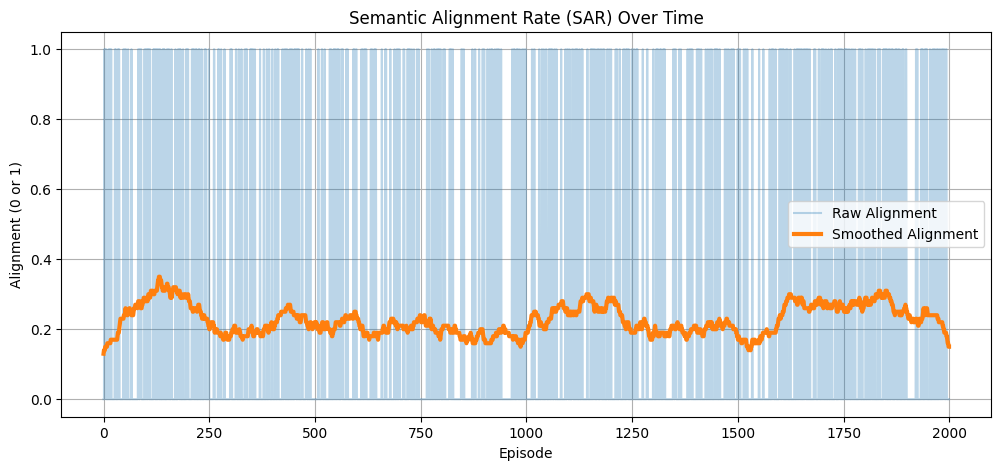

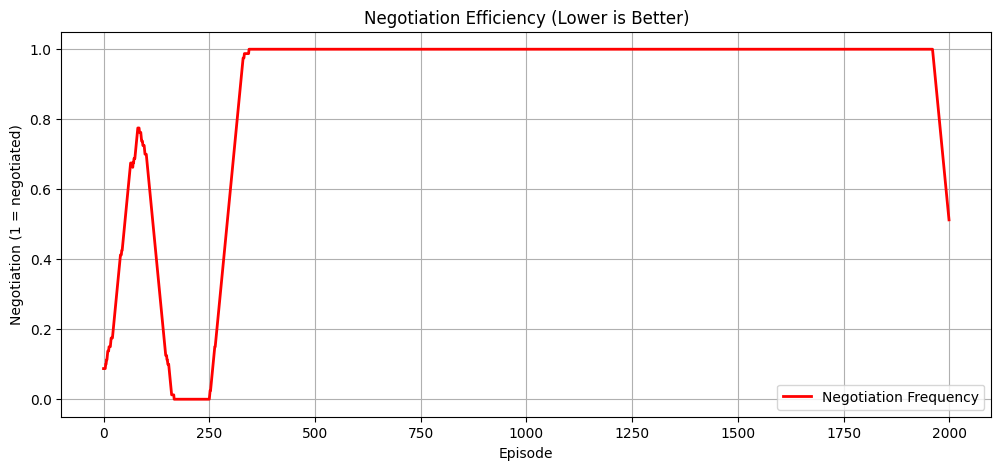

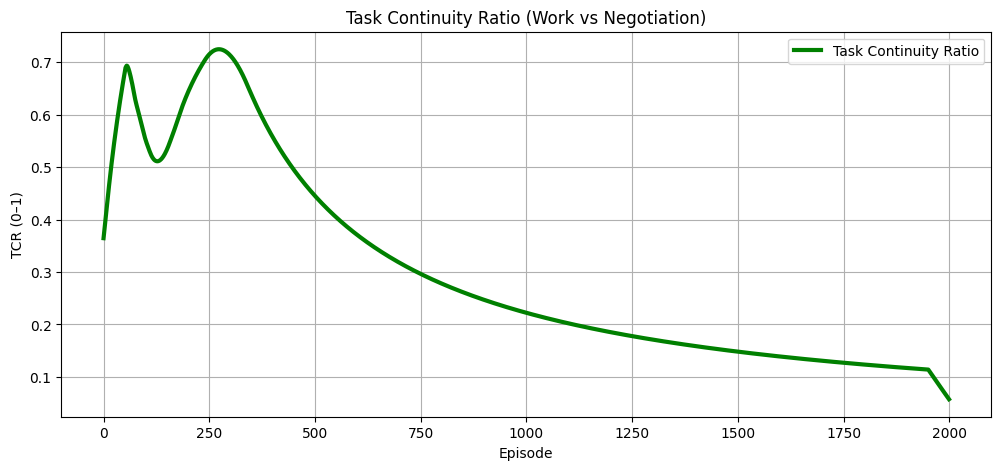

HLSCSN metric plots generated ✔


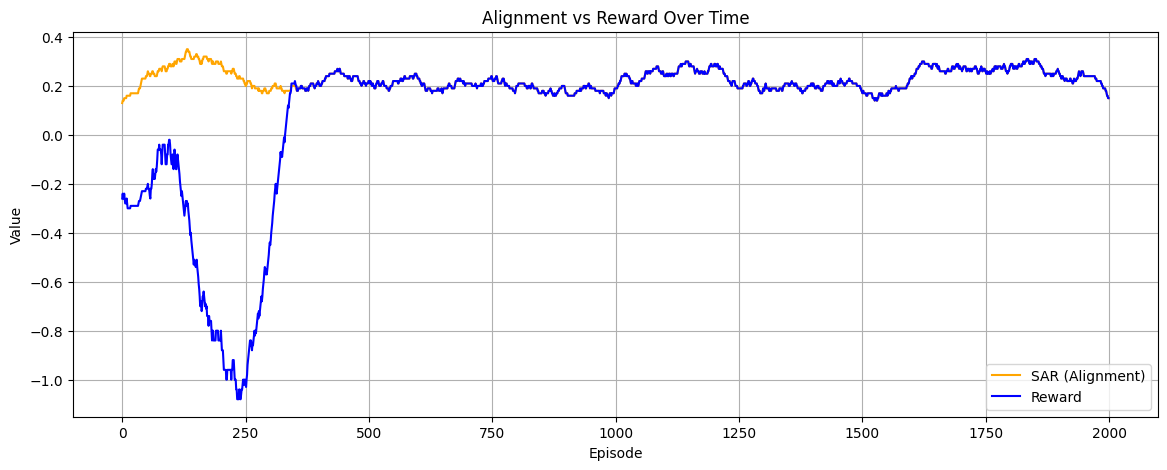

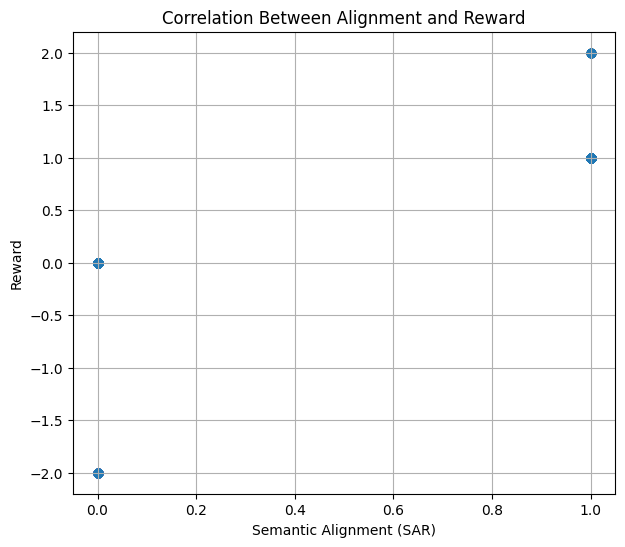

In [43]:
# ----------------------------------------------------
# 8.7 PLOT HLSCSN METRICS (SAR, NE, TCR)
# ----------------------------------------------------
# WHAT IS THIS?
#   - These plots visualize how the HLSCSN model performs over time.
#   - They show exactly what I described in my draft:
#         • Semantic Alignment Rate increases with interactions
#         • Negotiation Efficiency improves (fewer negotiations needed)
#         • Task Continuity Ratio stabilizes as agents learn
#
# WHY ARE WE DOING THIS?
#   - Because my professor expects evaluation metrics
#   - These plots make the results *visible and measurable*
#   - They will be used directly in my slides and report

import matplotlib.pyplot as plt
import numpy as np

# Helper function for smoothing curves
def smooth(data, window=100):
    if len(data) < window:
        return np.array(data)
    return np.convolve(data, np.ones(window)/window, mode='same')


# ----------------------------
# Plot 1: Semantic Alignment Rate (SAR)
# ----------------------------
plt.figure(figsize=(12,5))
plt.plot(SAR_list, alpha=0.3, label="Raw Alignment")
plt.plot(smooth(SAR_list, 100), linewidth=3, label="Smoothed Alignment")
plt.title("Semantic Alignment Rate (SAR) Over Time")
plt.xlabel("Episode")
plt.ylabel("Alignment (0 or 1)")
plt.legend()
plt.grid(True)
plt.show()


# ----------------------------
# Plot 2: Negotiation Efficiency (NE)
# ----------------------------
plt.figure(figsize=(12,5))
plt.plot(smooth(NE_list, 80), color="red", linewidth=2, label="Negotiation Frequency")
plt.title("Negotiation Efficiency (Lower is Better)")
plt.xlabel("Episode")
plt.ylabel("Negotiation (1 = negotiated)")
plt.grid(True)
plt.legend()
plt.show()


# ----------------------------
# Plot 3: Task Continuity Ratio (TCR)
# ----------------------------
plt.figure(figsize=(12,5))
plt.plot(smooth(TCR_list, 100), color="green", linewidth=3, label="Task Continuity Ratio")
plt.title("Task Continuity Ratio (Work vs Negotiation)")
plt.xlabel("Episode")
plt.ylabel("TCR (0–1)")
plt.grid(True)
plt.legend()
plt.show()

print("HLSCSN metric plots generated ✔")

# plot:  Alignment vs Reward (smoothed curves)
plt.figure(figsize=(14,5))

plt.plot(smooth(SAR_list, 100), label="SAR (Alignment)", color="orange")
plt.plot(smooth(HLSCSN_rewards, 100), label="Reward", color="blue")

plt.title("Alignment vs Reward Over Time")
plt.xlabel("Episode")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()

# Plot 2 — Alignment vs Reward (scatter relationship)
plt.figure(figsize=(7,6))
plt.scatter(SAR_list, HLSCSN_rewards, alpha=0.3)
plt.xlabel("Semantic Alignment (SAR)")
plt.ylabel("Reward")
plt.title("Correlation Between Alignment and Reward")
plt.grid(True)
plt.show()





In [45]:
!git config --global user.email "sadianz@gmail.com"
!git config --global user.name "sadiaNz"